# Video Analysis Pipeline

Videos can be analysed quickly using this script. This allows for rapidly testing different conditions while maintaining low statistical errors.

In [24]:
import numpy as np
import bubble as bubl
import lmfit

%matplotlib notebook
from matplotlib import pyplot as plt

In [8]:
# Load the video and do check if the bubbles
# are detected correctly
track = bubl.Tracker()
track.load_video("./videos/vid-10.mp4")

734

### Use this to adjust detection settings for video

Total number of points: 85


<IPython.core.display.Javascript object>


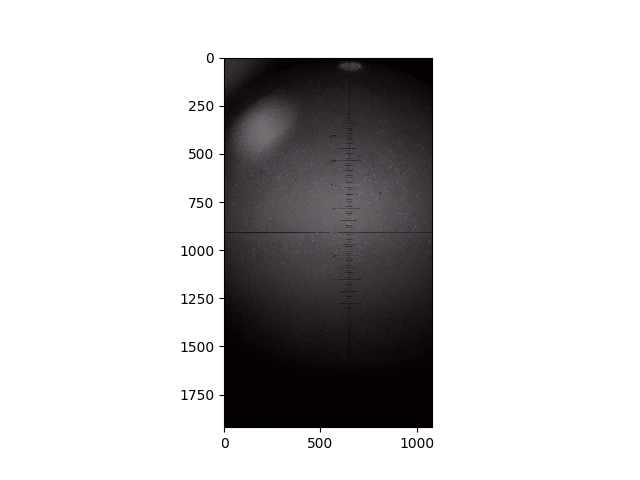

In [9]:
# Determine detection settings (manually as per video quality)
track.params.minArea = 1
track.params.maxThreshold = 255 * 0.66

pts, img = track.test_keypoints(0)
print("Total number of points:", len(pts))

_, ax = plt.subplots()
ax.imshow(img)
plt.show()

### Adjust data transform
Use the above view to determine the position of the center and the lower mark ('4'). Also enter the video time, the time at which the voltage was turned on, and the voltage.

In [10]:
# Fill these in for the given video

# vide0 12
pos_center  = (648.9, 909.4) # (x, y)
pos_lower   = (648.9, 1030.8) # (x, y)
time_full   = 28.0 # in seconds
time_switch = 10.4 # in seconds
voltage = 554.0 # in volts

# video 11
pos_center  = (647.5, 909.4) # (x, y)
pos_lower   = (647.5, 1031.5) # (x, y)
time_full   = 24.0 # in seconds
time_switch = 10.4 # in seconds
voltage = 550.0 # in volts

# Variables given by lab-book
microscope_scale = 0.5e-3 # in meters
viscosity = 1.832e-5
density = 871.0
d = 6e-3 # +/- 0.05 mm
g = 9.807 # in meters per seocond squared
e = 1.6e-19 # in Coulomb
stokes_correction = .874 # [Millikan]
mean_free_path = 68e-9 # for air at 25C, [Jennings, S (1988). "The mean free path in air". Journal of Aerosol Science. 19 (2): 159.]


In [18]:
# Track bubbles (the magic part)
track.track()

In [12]:
# Obtain trajectories
traces = [b.trajectory for b in track.bubbles]
times  = [np.array(range(b.first_seen, b.last_seen+1)) * time_full / (len(track.frames)-1) for b in track.bubbles]

In [ ]:
# be kind to your ram
del track

## Filter data
Include only traces that cross the voltage transition and only consider a 100 frame neighbourhood.

Here, we also transform the data from pixel and frame to physical 

In [13]:
f_traces = []
f_times  = []
neighbourhood = 100

for i, trace in enumerate(traces):
    # Find index at time_switch
    idx_switch = None
    for j in range(1, len(times[i])):
        if times[i][j-1] < time_switch and times[i][j] >= time_switch:
                   idx_switch = j
                   break
    if idx_switch is None:
                   continue
    # Grab slice of 100 frame neighbourhood
    tr = trace[idx_switch - neighbourhood:idx_switch + neighbourhood + 1]
    ti = times[i][idx_switch - neighbourhood:idx_switch + neighbourhood + 1]
    if len(tr) == neighbourhood * 2 + 1:
        f_traces.append(tr)
        f_times.append(ti)

# Count the results
print("Number of final data points:", len(f_traces))

Number of final data points: 21


In [14]:
# Rotate points and convert to meters
theta = np.arctan((pos_lower[0]-pos_center[0])/(pos_lower[1]-pos_center[1]))
rotation = np.array([
    [np.cos(theta), -np.sin(theta)],
    [np.sin(theta), np.cos(theta)]
])

# Rotate each point and scale to correct units
origin = np.array(pos_center)
for i, trace in enumerate(f_traces):
    f_traces[i] = np.matmul(rotation, (trace-origin).transpose()).transpose()
    f_traces[i] = f_traces[i] * microscope_scale / (pos_lower[1]-pos_center[1])

In [15]:
# Obtain approximate instantaneous velocities
if len(f_traces[0]) != 2 * neighbourhood:
    f_vels = []
    for idx, trace in enumerate(f_traces):
        f_vels.append(np.array([(trace[i] - trace[i-1]) / (f_times[idx][i] - f_times[idx][i-1]) for i in range(1, len(trace))]))
        f_traces[idx] = trace[:-1]
        f_times[idx] = f_times[idx][:-1]
print(len(f_traces), len(f_times), len(f_vels))
print(len(f_traces[0]), len(f_times[0]), len(f_vels[0]))

21 21 21
200 200 200


# Data Analysis
Now we have access to three data sets for the successfully traced droplets: `f_traces`, `f_times` and `f_vels`, which contain the position, time and approximate instantaneous velocity of the bubbles.

The cell below plots all of this data. Set index to some number, to see a specific droplet. Reset to `None` to show all droplets.

<IPython.core.display.Javascript object>


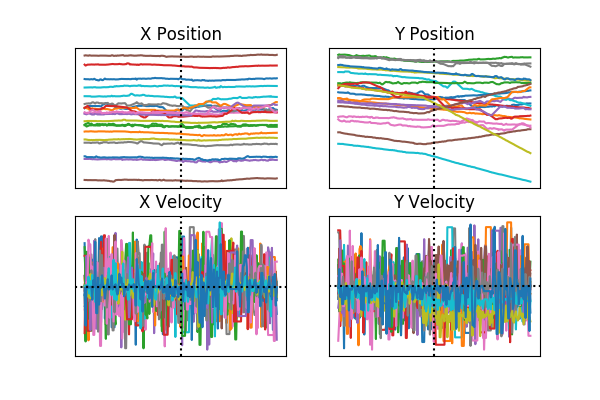

In [20]:
# Plot the obtained data
index = None

_, ax = plt.subplots(2, 2, figsize=(6, 4))

# Position
for i, trace in enumerate(f_traces):
    if i == index or index == None:
        ax[0][0].plot(f_times[i], [p[0] for p in trace])
for i, trace in enumerate(f_traces):
    if i == index or index == None:
        ax[0][1].plot(f_times[i], [p[1] for p in trace])
# Velocity
for i, vel in enumerate(f_vels):
    if i == index or index == None:
        ax[1][0].plot(f_times[i], [v[0] for v in vel])
for i, vel in enumerate(f_vels):
    if i == index or index == None:
        ax[1][1].plot(f_times[i], [v[1] for v in vel])
    
for i, _ax in enumerate(ax[0]):
    _ax.set_title("X Position" if i == 0 else "Y Position")
    _ax.axvline(time_switch, color="black", linestyle="dotted")
    _ax.set_xticks([])
    _ax.set_yticks([])
for i, _ax in enumerate(ax[1]):
    _ax.set_title("X Velocity" if i == 0 else "Y Velocity")
    _ax.axvline(time_switch, color="black", linestyle="dotted")
    _ax.axhline(0, color="black", linestyle="dotted")
    _ax.set_xticks([])
    _ax.set_yticks([])

plt.show()

In [22]:
# Analysis functions from lab-book
def q_obs(v_g, v_e):
    a = 6 * np.pi * np.sqrt(9/2)
    b = viscosity**(3/2) / np.sqrt(density * g)
    c = np.sqrt(abs(v_g)) * (v_e - v_g) / voltage * d
    return a * b * c

def radius(v_g):
    return np.sqrt(abs(9/2 * viscosity / density / g * (-v_g)))

def q(q_obs, alpha=0):
    # Note: alpha = b * l / a in lab-book terms
    return (1/(1+alpha))**(3/2) * q_obs

def q_corrected(v_g, v_e):
    return q(q_obs(v_g, v_e), stokes_correction * mean_free_path / radius(v_g))

<IPython.core.display.Javascript object>


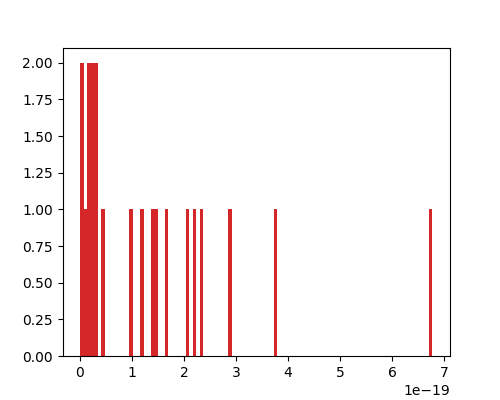

In [29]:
# Determine q_obs for all data items
q_list = []
radius_list = []
for i, vel in enumerate(f_vels):
    q_list.append(q_corrected(
        np.mean(vel[:neighbourhood], axis=0)[1],
        np.mean(vel[neighbourhood:], axis=0)[1]
    ))
    radius_list.append(radius(vel[:neighbourhood]))
q_list = abs(np.array(q_list))

# Plot the results
_, ax = plt.subplots(figsize=(5,4))
ax.hist(q_list, bins=100, color="tab:red")
plt.show()

<IPython.core.display.Javascript object>


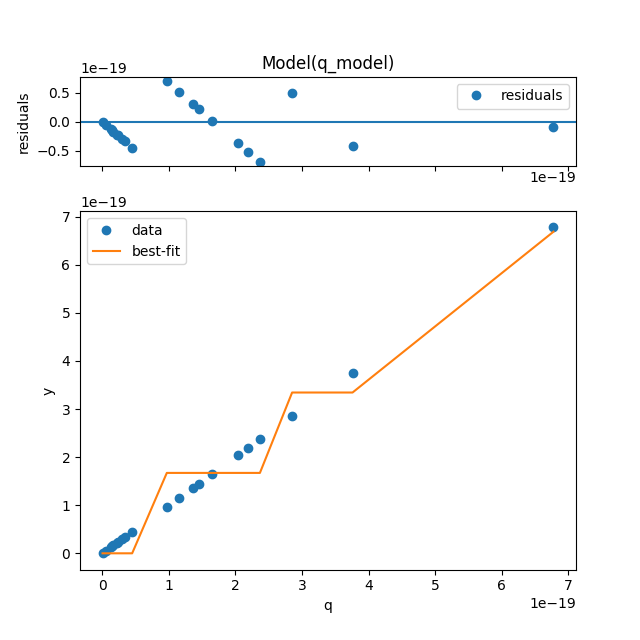

[[Model]]
    Model(q_model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 4
    # data points      = 21
    # variables        = 1
    chi-square         = 2.7839e-38
    reduced chi-square = 1.3920e-39
    Akaike info crit   = -1877.89677
    Bayesian info crit = -1876.85225
[[Variables]]
    e:  1.6720e-19 +/- 6.5954e-21 (3.94%) (init = 1.65e-19)



In [32]:
charges = sorted(q_list)

def q_model(q, e):
    return np.round(q/e) * e

model = lmfit.Model(q_model)
params = model.make_params()

params.add("e", value=6.6e-19 / 4)
res = model.fit(charges, params, q=charges)

res.plot()
plt.show()
print(res.fit_report())